# 基于神经网络的手写数字识别

- 明天就要回学校准备实习了，趁着最后一天清闲完成这个小实验。
- 使用的数据集是 MNIST。
- 完全自己实现神经网络的训练过程，仔细体会了反向传播的流程。

In [1]:
# load package

import neural_network as nn
import mnist_loader as ml
import matplotlib.pyplot as plt
import cv2
import numpy as np

## 加载数据集

- 这里使用了一个脚本 *mnist_loader.py*, 将 MNIST 数据集分割为训练集、验证集、测试集。
- 展示了其中一幅训练图片，为数字 1.
- 同时，我们也打印出训练集中每个 example 的大小。

(784, 1) (10, 1)


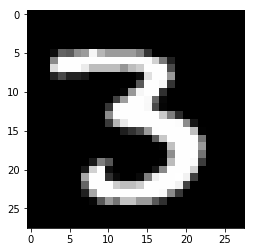

In [2]:
# load MNIST data

training_data, validation_data, test_data = ml.load_data_wrapper()

# show the input data
index = 12
x, y = training_data[index]
print(x.shape, y.shape)
plt.imshow(x.reshape((28,28)), 'gray')

## 网络结构与超参数选择

### Ex1
- 我们首先尝试的网络结构为：输入层 - 隐含层 - 输出层 （784 - 100 - 10）
- 迭代 20 次，学习率为 0.03，批梯度下降的batch size为 100.

In [3]:
# create neural network

# units of all layers
architech = [784, 100, 10]

# iteration numbers
num_iter = 20

# learning rate
alpha = 0.03

# regularization parameter
lambd = 1.2

model = nn.NeuralNetwork(architech, num_iter, alpha, lambd)

2018-08-11 10:00:27,960: INFO: epoch 0/20 acc : 0.4084
2018-08-11 10:00:39,669: INFO: epoch 2/20 acc : 0.819
2018-08-11 10:00:51,329: INFO: epoch 4/20 acc : 0.9291
2018-08-11 10:01:02,735: INFO: epoch 6/20 acc : 0.944
2018-08-11 10:01:14,235: INFO: epoch 8/20 acc : 0.9485
2018-08-11 10:01:25,680: INFO: epoch 10/20 acc : 0.9542
2018-08-11 10:01:37,024: INFO: epoch 12/20 acc : 0.9559
2018-08-11 10:01:48,276: INFO: epoch 14/20 acc : 0.9601
2018-08-11 10:01:59,604: INFO: epoch 16/20 acc : 0.9632
2018-08-11 10:02:10,949: INFO: epoch 18/20 acc : 0.9624


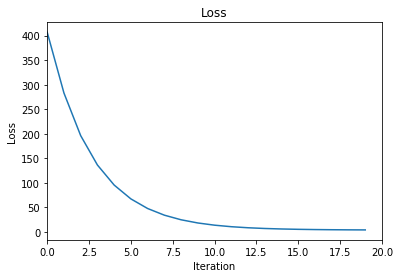

Test data acc : 0.9569


In [4]:
# train model

model.train_model(training_data, test_data=validation_data)

acc = model.evaluate(test_data)
print("Test data acc : {0}".format(acc))

### Ex2
- 将网络结构改为：输入层 - 隐含层 - 输出层 （784 - 64 - 32 - 10）
- 迭代 20 次，学习率为 0.03，批梯度下降的batch size为 100.

2018-08-11 10:02:31,065: INFO: epoch 0/20 acc : 0.8056
2018-08-11 10:02:41,765: INFO: epoch 2/20 acc : 0.9123
2018-08-11 10:02:52,415: INFO: epoch 4/20 acc : 0.9356
2018-08-11 10:03:02,972: INFO: epoch 6/20 acc : 0.9454
2018-08-11 10:03:13,472: INFO: epoch 8/20 acc : 0.9527
2018-08-11 10:03:23,985: INFO: epoch 10/20 acc : 0.9584
2018-08-11 10:03:34,828: INFO: epoch 12/20 acc : 0.9576
2018-08-11 10:03:45,225: INFO: epoch 14/20 acc : 0.9586
2018-08-11 10:03:55,751: INFO: epoch 16/20 acc : 0.9597
2018-08-11 10:04:06,337: INFO: epoch 18/20 acc : 0.9639


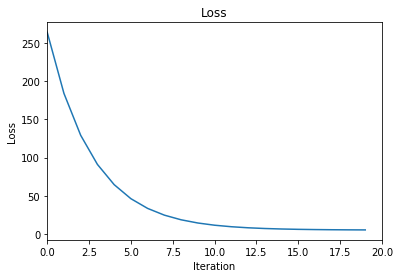

Test data acc : 0.9604


In [5]:
# create neural network

# units of all layers
architech = [784, 64, 32, 10]

# iteration numbers
num_iter = 20

# learning rate
alpha = 0.03

# regularization parameter
lambd = 1.2

model = nn.NeuralNetwork(architech, num_iter, alpha, lambd)

# train model

model.train_model(training_data, test_data=validation_data)

acc = model.evaluate(test_data)
print("Test data acc : {0}".format(acc))

## 手写数字识别

- 这里我将自己手写的一串数字作为检测目标，进行分析、识别。
- 基本流程：
    - 1. 图像预处理，如：转换为灰度图像、二值化、形态学操作。
    - 2. 连通域分析，分割出数字部分。
    - 3. 将每个数字图像部分送入上面得到的神经网络模型，得到预测结果。

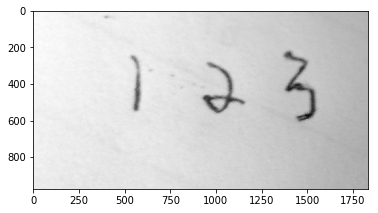

In [6]:
file_name = 'data\\my_image.jpg'

# read the image
image = cv2.imread(file_name, 0)
plt.imshow(image, 'gray')

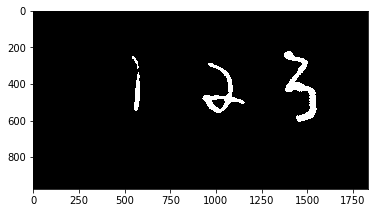

In [7]:
# binarize
_, b_image =  cv2.threshold(image,155,255,cv2.THRESH_BINARY)
b_image = cv2.bitwise_not(b_image) / 255
plt.imshow(b_image, 'gray')

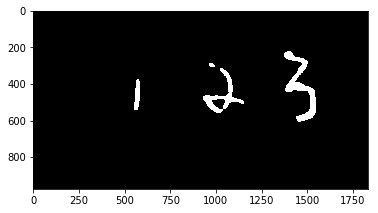

In [8]:
# 形态学处理
t_image = cv2.morphologyEx(b_image, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (15,15)))
plt.imshow(t_image, 'gray')

### 分割字符

- 这里使用投影的方法，将图像向水平与垂直两个方向投影（叠加像素）。
- 由下图可以观察到，在图片中，累计像素最多的水平位置与垂直位置正是分割的坐标。
- 如此一来，我们就可以分割出图片中的数字部分。

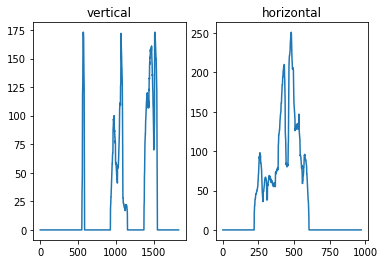

In [9]:
h, w = t_image.shape

vertical = [np.sum(t_image[:, i]) for i in range(w)]
horizontal = [np.sum(t_image[i, :]) for i in range(h)]

plt.subplot(1,2,1)
plt.title("vertical")
plt.plot(range(w), vertical)

plt.subplot(1,2,2)
plt.title("horizontal")
plt.plot(range(h), horizontal)

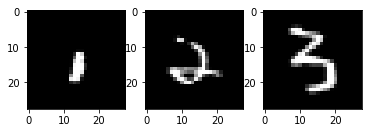

In [10]:
w_pos = []
h_pos = []
padding = 100
start = 0
for i in range(w-1):
    if vertical[i] == 0 and vertical[i+1] != 0:
        start = i
    elif vertical[i] != 0 and vertical[i+1] == 0:
        w_pos.append((start, (i-start)))

for i in range(h-1):
    if horizontal[i] == 0 and horizontal[i+1] != 0:
        start = i
    elif horizontal[i] != 0 and horizontal[i+1] == 0:
        h_pos.append((start, (i-start)))

img = image
numbers_img = []
raw_img = []
img_size = (28,28)
cnt = len(w_pos)
for i, pos in enumerate(w_pos):
    x, w = pos
    y, h = h_pos[0]
    raw_img.append(image[y:y+h, x:x+w])
    crop_img = cv2.resize(t_image[y-padding:y+padding+h, x-padding:x+padding+w], img_size, interpolation=cv2.INTER_AREA)
    numbers_img.append(crop_img)
    plt.subplot(1,cnt, i+1)
    plt.imshow(crop_img, 'gray')

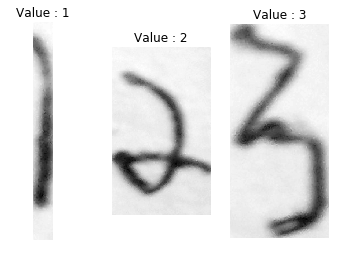

In [11]:
cnt = len(numbers_img)
for i, num in enumerate(numbers_img):
    y = model.predict(num.reshape([-1, 1]))
    plt.subplot(1,cnt,i+1)
    plt.title("Value : {0}".format(y))
    plt.imshow(raw_img[i], 'gray')
    plt.axis('off')


# Summary

1. 在神经网络训练部分，超参数的选择对于模型有着很大的影响。上面实验中使用的参数是我调试了几次后得到的。
2. 在最后手写数字的识别实验部分，一开始识别效果很差。经过检查，发现是裁剪数字部分时，没有在数字四周留出空余部分，导致每次识别效果很差。最后在裁剪时留出了较大的空余部分，得到了很棒的识别效果。